In [1]:
import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation 

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import * # plot_bloch_multivector
from ibm_quantum_widgets import * # CircuitComposer
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
circuit = QuantumCircuit(1,1)
circuit.ry(pi/2,0)
circuit.tdg(0)
editor = CircuitComposer(circuit=circuit)
editor

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000024F5C67C400>)

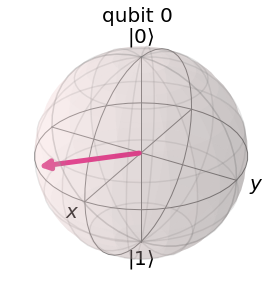

In [3]:
qc1 = editor.circuit
plot_bloch_multivector(qc1)

In [4]:
# Run the circuit with the state vector simulator to obtain a noise-free fractal.
backend = Aer.get_backend('statevector_simulator')
out = execute(qc1,backend).result().get_statevector()

# Extract the first element of the state vector as z0 and the second element as z1.
z0 = out.data[0]
z1 = out.data[1]

# The straightforward way to obtain one complex number for the Julia set fractal 
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

# Define the size & escape threshold
size = 1000
heightsize = size
widthsize = size
escapeno = 2

def julia_set1CN(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m] 
        m[np.abs(z) > escapeno] = False 
        div_time[m] = i
    return div_time


def julia_set2CN1(c0=z0, c1=z1, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize the c's to the complex amplitudes obtained from the quantum circuit
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool)
    for i in range(max_iterations):
        z[m] = (z[m]**2 + c0[m]) / (z[m]**2 + c1[m]) # julia set mating 1
        m[np.abs(z) > escapeno] = False
        div_time[m] = i
    return div_time

def julia_set2CN2(c0=z0, c1=z1, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    # Initialize the c's to the complex amplitudes obtained from the quantum circuit
    c0 = np.full(z.shape, c0)
    c1 = np.full(z.shape, c1)
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    # To keep track on which points did not converge so far
    m = np.full(c0.shape, True, dtype=bool) 
    for i in range(max_iterations):
        z[m] = (c0[m]*z[m]**2 + 1 - c0[m]) / (c1[m]*z[m]**2 + 1 - c1[m]) # julia set mating 2
        m[np.abs(z) > escapeno] = False 
        div_time[m] = i
    return div_time

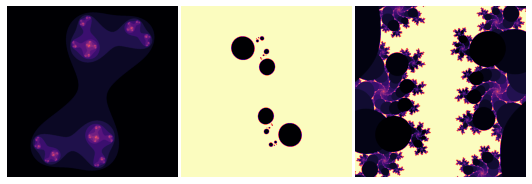

In [5]:
fig = plt.figure(figsize=(12, 12)) 

gs = gridspec.GridSpec(1, 3, 
         wspace=0.02, hspace=0.0, 
         #top=0.95, bottom=0.05, 
         left=0.2, right=0.8) 

ax = plt.subplot(gs[0,0])
ax.imshow(julia_set1CN(), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[0,1])
ax.imshow(julia_set2CN1(), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[0,2])
ax.imshow(julia_set2CN2(), cmap='magma')
ax.axis('off')

plt.show()

# Running on a real quantum computer
### Identify least busy system, perform measurements and run on backend

In [6]:
# Find the least busy system that has at least 1 qubit
from qiskit.providers.ibmq import least_busy

ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 1 and 
                                   not x.configuration().simulator and x.status().operational==True))

print(ibmq_backend)

ibmq_lima


In [7]:
qc1.measure(0, 0)
qc1.draw()

┌─────────┐┌─────┐┌─┐
  q: ┤ Ry(π/2) ├┤ Tdg ├┤M├
     └─────────┘└─────┘└╥┘
c: 1/═══════════════════╩═
                        0

In [11]:
shotno=1024
job_ibmq = execute(qc1, ibmq_backend, shots=shotno)
result = job_ibmq.result()

## Perform calculations and plot result

In [12]:
# Get count measurement results
counts = result.get_counts()

prob0qc = counts['0']/shotno
prob1qc = counts['1']/shotno

prob0statevec = out.probabilities()[0]
prob1statevec = out.probabilities()[1]

# one simple approach to calculate quantum computer-modified complex amplitudes # amplitude^2 = probability
z0qc = z0*sqrt(prob0qc/prob0statevec)
z1qc = z1*sqrt(prob1qc/prob1statevec)
zqc = z0qc/z1qc

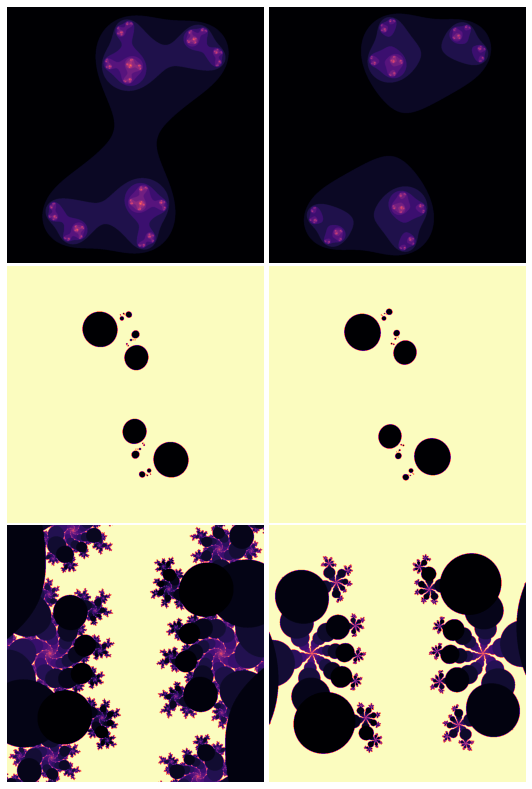

In [13]:
fig = plt.figure(figsize=(12, 12)) 

gs = gridspec.GridSpec(3, 2, width_ratios=[1,1],
         wspace=0.02, hspace=0.0, 
         top=0.95, bottom=0.05, 
         left=0.2, right=0.8) 

ax = plt.subplot(gs[0,0])
ax.imshow(julia_set1CN(c=z), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[0,1])
ax.imshow(julia_set1CN(c=zqc), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[1,0])
ax.imshow(julia_set2CN1(c0=z0,c1=z1), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[1,1])
ax.imshow(julia_set2CN1(c0=z0qc,c1=z1qc), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[2,0])
ax.imshow(julia_set2CN2(c0=z0,c1=z1), cmap='magma')
ax.axis('off')
ax = plt.subplot(gs[2,1])
ax.imshow(julia_set2CN2(c0=z0qc,c1=z1qc), cmap='magma')
ax.axis('off')

plt.show()